# EDA

In [189]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from typing import List, Optional
import numpy as np
from scipy import stats

In [190]:
#!kaggle datasets download -d laotse/credit-risk-dataset

#! unzip "credit-risk-dataset.zip"

In [191]:
# Load the dataset from a CSV file into a pandas DataFrame
ds_raw = pd.read_csv('credit_risk_dataset.csv')

# Display basic information about the dataset: data types, non-null values, etc.
ds_raw.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [192]:

# Display the second row to verify the data content
print(ds_raw.iloc[1, :])

person_age                           21
person_income                      9600
person_home_ownership               OWN
person_emp_length                   5.0
loan_intent                   EDUCATION
loan_grade                            B
loan_amnt                          1000
loan_int_rate                     11.14
loan_status                           0
loan_percent_income                 0.1
cb_person_default_on_file             N
cb_person_cred_hist_length            2
Name: 1, dtype: object


In [193]:
# Separate the target variable (loan_status) from the feature set
target = ds_raw['loan_status']  # 'loan_status' is the target variable to predict
X = ds_raw.drop('loan_status', axis=1)  # Drop the target column from the feature set


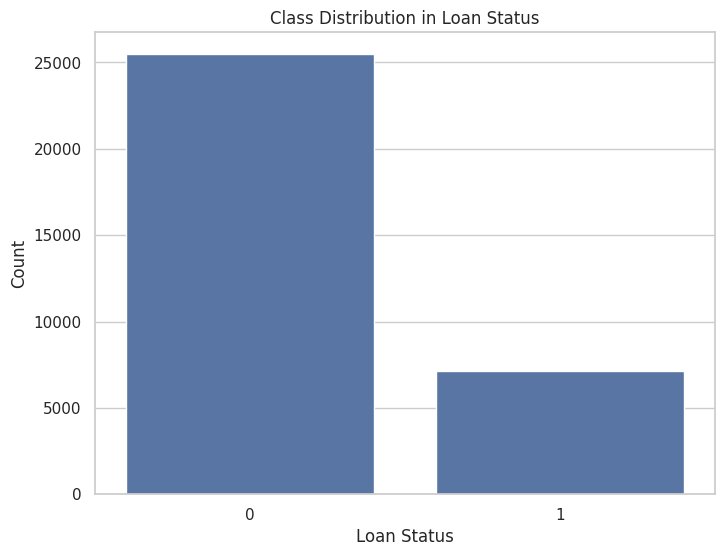

In [194]:
plt.figure(figsize=(8, 6))
sns.countplot(x=target)
plt.title('Class Distribution in Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.show()

In [195]:
# Separate numerical and categorical columns
num_columns = X.select_dtypes(include=['number']).columns.tolist()
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()

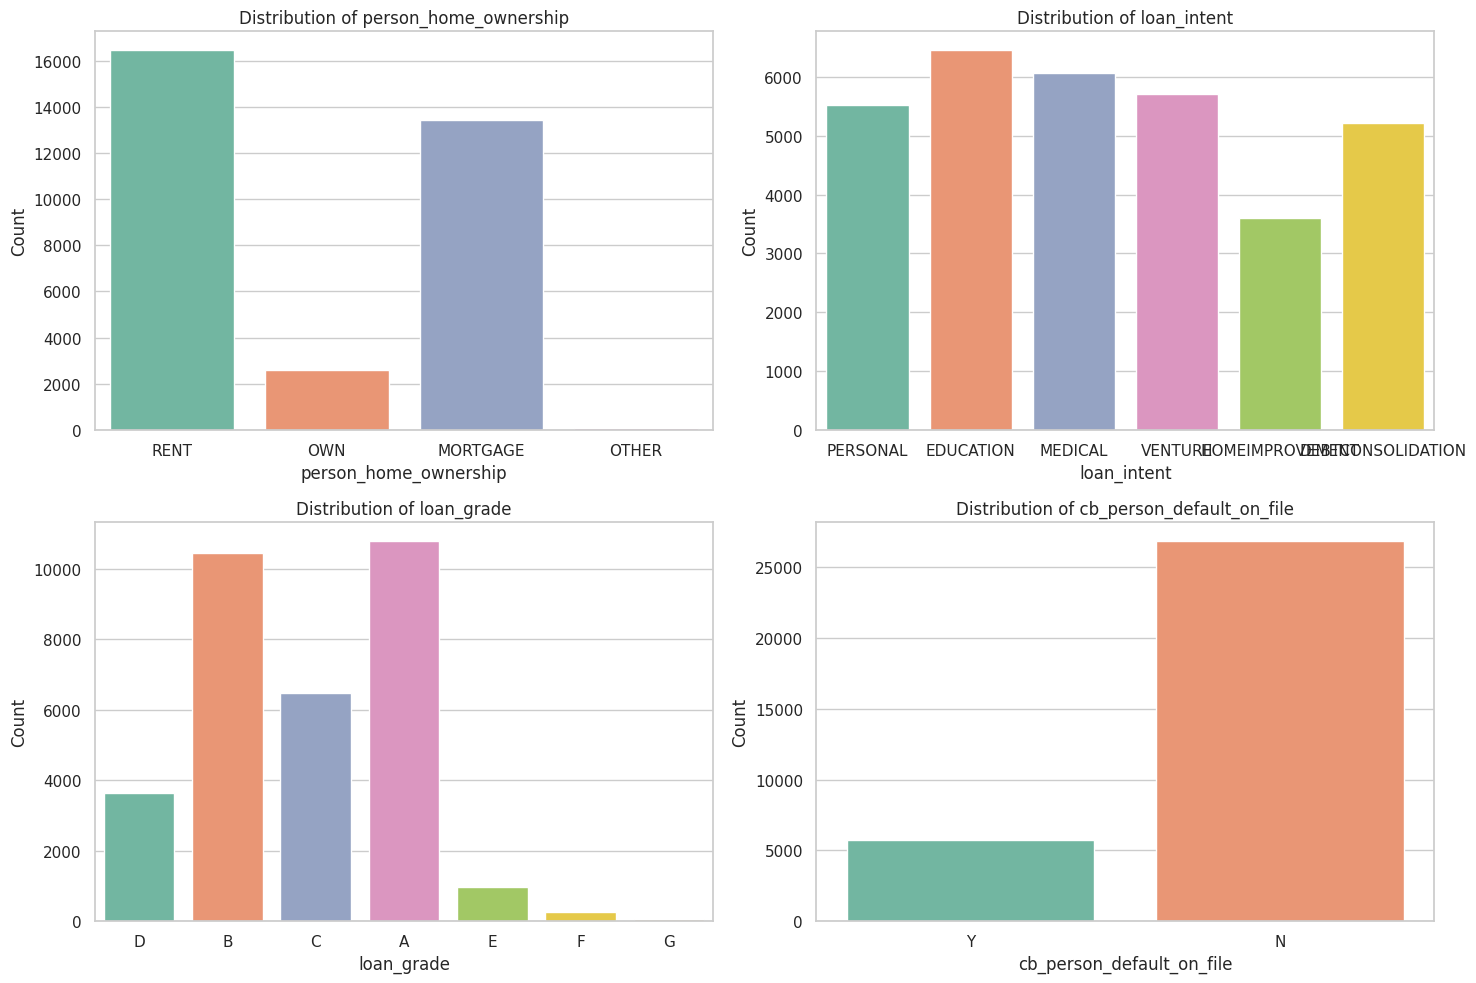

In [196]:
# Set seaborn plot theme for consistent styling
sns.set_theme(style="whitegrid")

# Plot distributions of categorical features
plt.figure(figsize=(15, 10))

# Calculate the number of rows and columns for the grid layout of plots
n_cols = 2  # Two columns in the grid
n_rows = (len(categorical_columns) // n_cols) + (1 if len(categorical_columns) % n_cols != 0 else 0)  # Rows dynamically calculated

# Plot a countplot for each categorical feature
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.countplot(x=ds_raw[col], hue=ds_raw[col], palette='Set2', legend=False)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')

# Adjust the layout to prevent overlapping of the plots
plt.tight_layout()
plt.show()

In [197]:
# Map loan grades to numerical values (e.g., A -> 7, B -> 6, etc.)
grade_values = ds_raw['loan_grade'].unique().tolist()  # Get the unique values of loan_grade
grade_dict = dict(zip(sorted(grade_values), range(7, 0, -1)))  # Map grades to numbers (A -> 7, B -> 6, ...)

# Apply the mapping to the 'loan_grade' column
X['loan_grade'] = X['loan_grade'].map(grade_dict)
# Remove 'loan_grade' from the list of categorical columns
categorical_columns.remove('loan_grade')

In [198]:
# Create dummy variables (one-hot encoding) for the remaining categorical columns
X_dummies = pd.get_dummies(X[categorical_columns], drop_first=True)

# Drop the original categorical columns as they have been encoded
X = X.drop(categorical_columns, axis=1)

# Concatenate the dummy variables back to the dataset
X = pd.concat([X, X_dummies], axis=1)


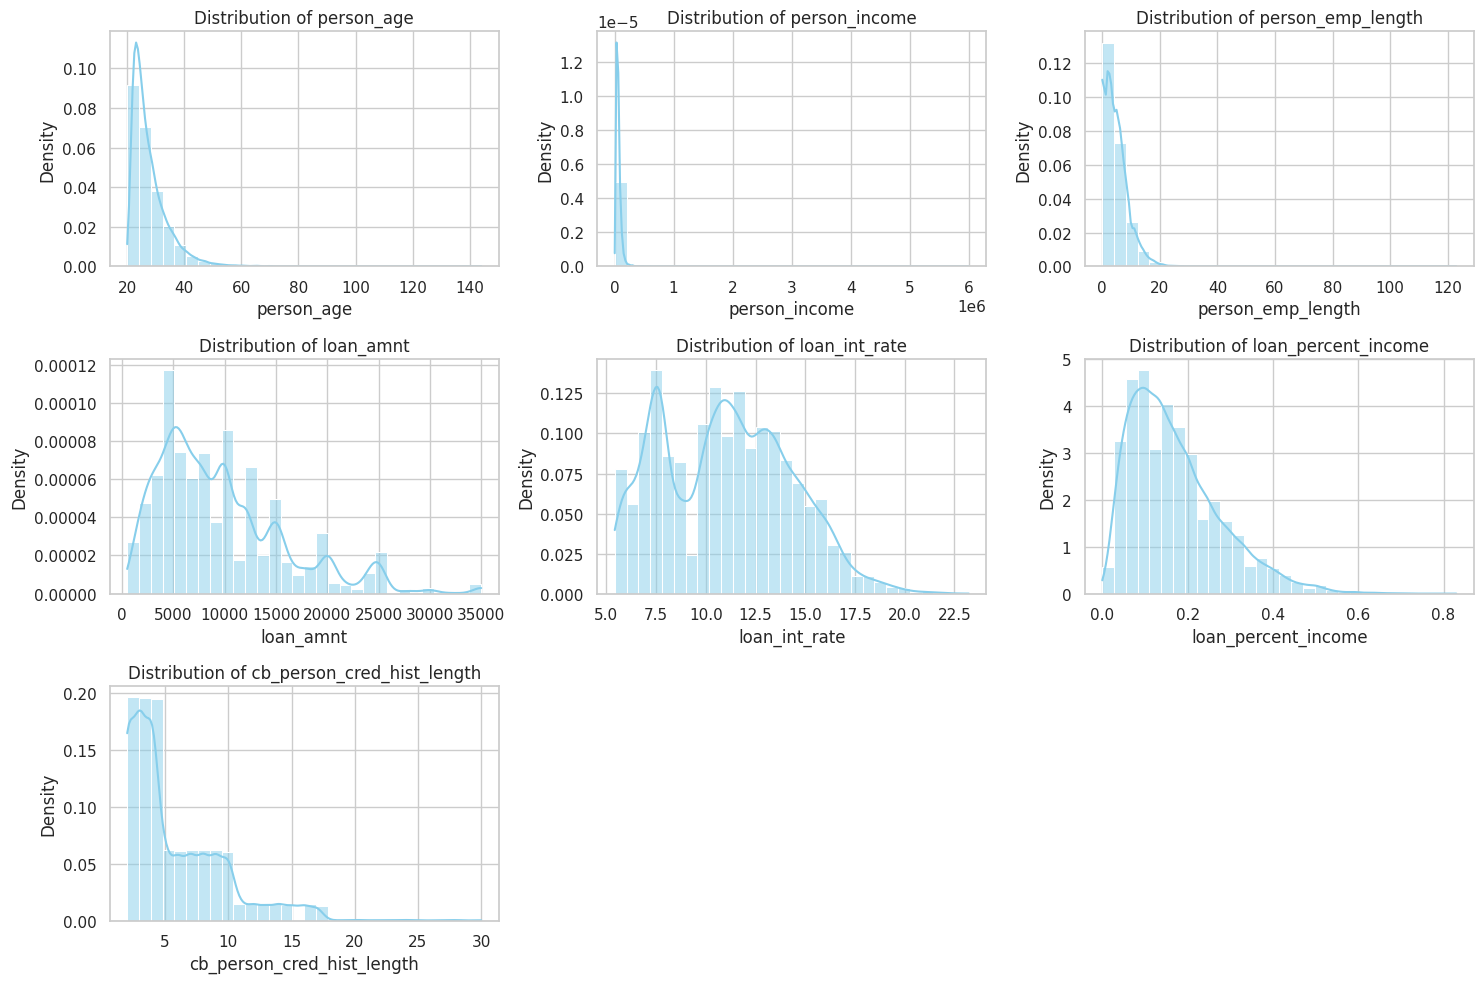

In [199]:
# Plot distributions for numerical features
plt.figure(figsize=(15, 10))

# Calculate the number of rows needed for the plot grid layout
n_cols = 3
n_rows = (len(num_columns) // n_cols) + (1 if len(num_columns) % n_cols != 0 else 0)

# Loop through numerical columns and create a histogram with Kernel Density Estimation (KDE) for each
for i, col in enumerate(num_columns, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(X[col], kde=True, bins=30, color='skyblue', stat='density')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Density')

# Adjust the layout to prevent overlapping of plots
plt.tight_layout()
plt.show()

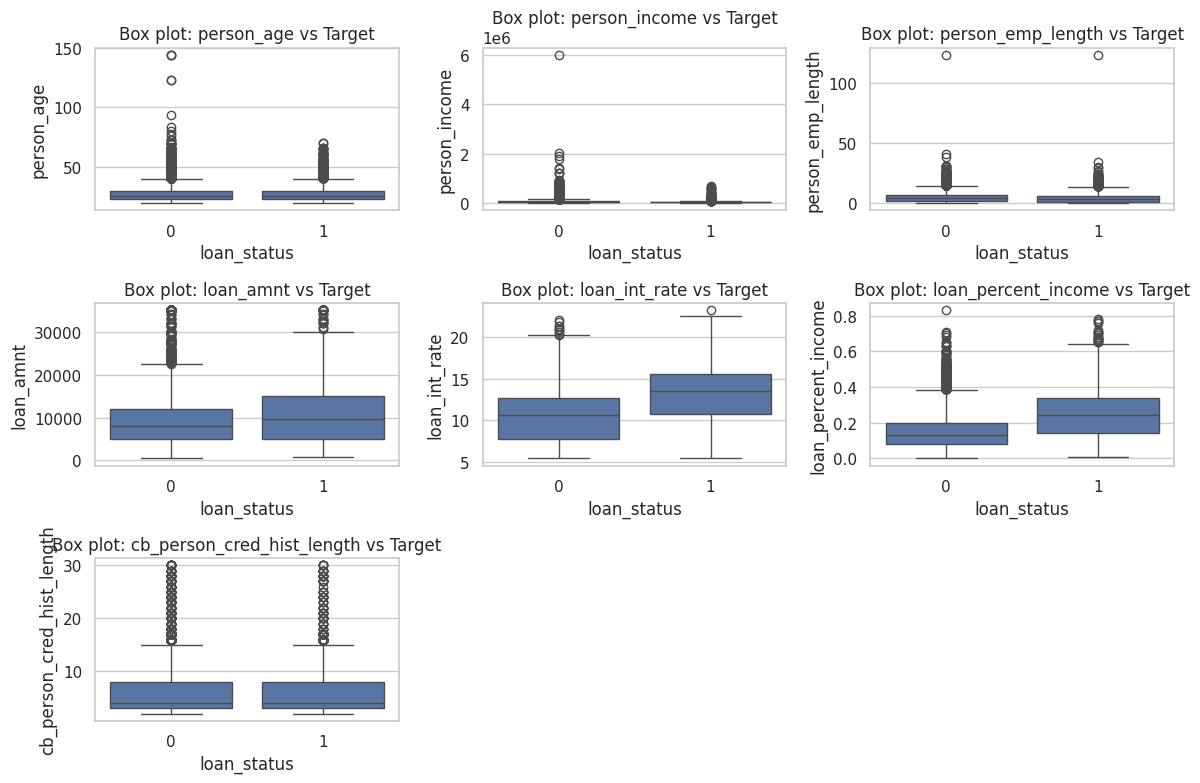

In [ ]:
# Create box plots to visualize the distribution of numerical features by target variable (loan_status)
plt.figure(figsize=(12, 8))

# Loop through each numerical column and create a boxplot for loan_status
for i, col in enumerate(num_columns, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x=target, y=X[col])
    plt.title(f"Box plot: {col} vs Target")

plt.tight_layout()
plt.show()

In [ ]:
def apply_quantile_binning(data: pd.DataFrame, column_name: str,
                           labels: Optional[List[int]] = [1, 2, 3, 4]) -> pd.DataFrame:
    """
    Apply quantile-based binning to the given column of the DataFrame and drop the original column.

    This function exactly mimics the process from the provided code, including calculating the quantiles,
    defining bin edges, applying the binning, and then dropping the original column.

    Parameters:
    - data (pd.DataFrame): The DataFrame containing the column to be binned.
    - column_name (str): The name of the column to be binned.
    - num_bins (int): Number of bins (default is 4, for quartiles).
    - labels (Optional[List[int]]): Optional list of integer labels for the bins (e.g., [1, 2, 3, 4]).

    Returns:
    - pd.DataFrame: The DataFrame with the binned column and the original column removed.
    """
    # Calculate the quartiles (25%, 50%, 75%)
    Q1 = data[column_name].quantile(0.25)
    Q2 = data[column_name].quantile(0.5)  # Median
    Q3 = data[column_name].quantile(0.75)

    # Calculate the minimum and maximum values
    min_value = data[column_name].min()
    max_value = data[column_name].max()

    # Define the bin edges (min, Q1, Q2, Q3, max)
    bins = [min_value, Q1, Q2, Q3, max_value]

    # Apply binning to the column using pd.cut
    data[f'{column_name}_binned'] = pd.cut(data[column_name], bins=bins, labels=labels, include_lowest=True)

    # Drop the original column after binning
    data = data.drop(column_name, axis=1)

    return data

    # Apply binning to the column based on quantiles
    data[f'{column_name}_binned'] = pd.cut(data[column_name], bins=quantiles, labels=labels, include_lowest=True)

    # Drop the original column after binning (optional)
    data = data.drop(column_name, axis=1, inplace=True)

    return data


In [ ]:
# Apply quantile binning to categorize 'cb_person_cred_hist_length' into 4 categories
X = apply_quantile_binning(X, 'cb_person_cred_hist_length')


In [ ]:
# Filter the 'person_age' column to remove any records where age is above 100 years
X = X[X['person_age'] <= 100]
target = target[X.index]

# Apply quantile binning for 'person_age', 'person_income', and 'person_emp_length'
X = apply_quantile_binning(X, 'person_age')
X = apply_quantile_binning(X, 'person_income')
X = apply_quantile_binning(X, 'person_emp_length')


In [ ]:
def boxcox_transformation(df: pd.DataFrame, column_name: str, lambda_val: Optional[float] = None):
    """
    Applies the Box-Cox transformation to a specified column in a pandas DataFrame.

    Parameters:
    - df: pandas DataFrame, the DataFrame containing the data.
    - column_name: str, the name of the column to transform.
    - lambda_val: float or None, the Box-Cox transformation parameter (lambda).
                  If None, the function will find the optimal lambda.

    Returns:
    - transformed_df: pandas DataFrame with the transformed column.
    """

    # Ensure the column exists in the DataFrame
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in the DataFrame.")

    # Extract the specified column and check for positive values
    data = df[column_name].values
    if np.any(data <= 0):
        raise ValueError(f"Data in column '{column_name}' must be positive for Box-Cox transformation.")

    # Apply Box-Cox transformation
    if lambda_val is None:
        # Find the optimal lambda using scipy's boxcox function
        transformed_data, lambda_optimal = stats.boxcox(data)
    else:
        # Apply the Box-Cox transformation with the specified lambda
        transformed_data = (data ** lambda_val - 1) / lambda_val if lambda_val != 0 else np.log(data)

    # Create a new DataFrame with the transformed column
    transformed_df = df.copy()
    transformed_df[column_name] = transformed_data

    return transformed_df


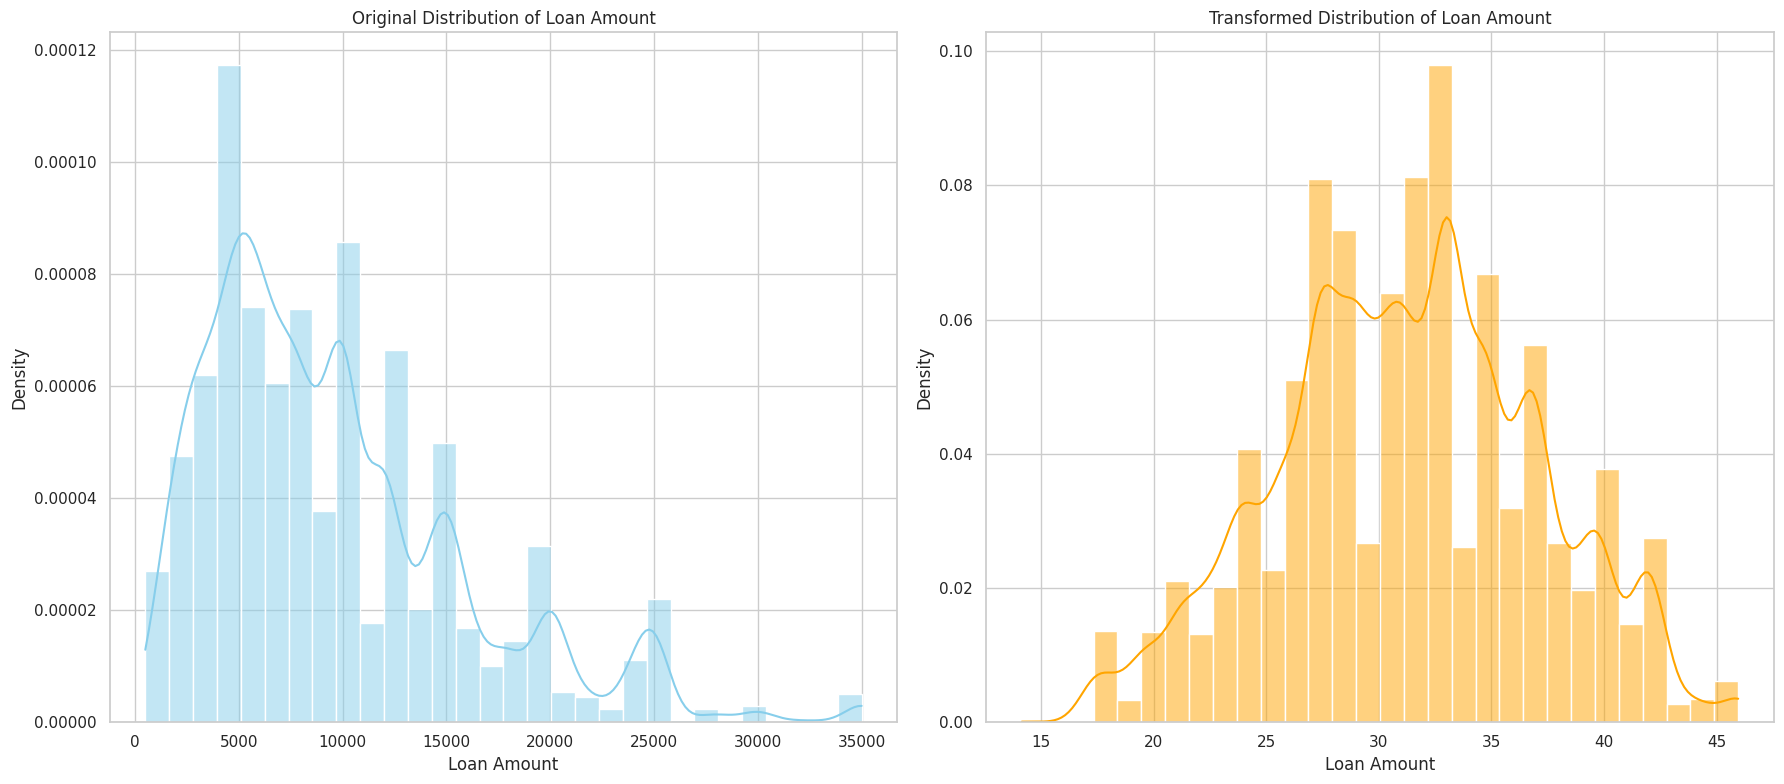

In [ ]:
# Recalculate numerical columns after binning
num_columns = X.select_dtypes(['number']).columns.tolist()

# Create a figure with two subplots side by side to compare distributions
plt.figure(figsize=(18, 8))  # Adjust the figure size to fit both plots side by side

# Plot the original distribution of 'loan_amnt' before Box-Cox transformation (First subplot)
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
sns.histplot(ds_raw['loan_amnt'], kde=True, bins=30, color='skyblue', stat='density')  # Original distribution
plt.title('Original Distribution of Loan Amount')
plt.xlabel('Loan Amount')
plt.ylabel('Density')

# Apply Box-Cox transformation to 'loan_amnt' for normalization
X = boxcox_transformation(X, 'loan_amnt')

# Plot the transformed distribution of 'loan_amnt' (Second subplot)
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
sns.histplot(X['loan_amnt'], kde=True, bins=30, color='orange', stat='density')  # Transformed distribution
plt.title('Transformed Distribution of Loan Amount')
plt.xlabel('Loan Amount')
plt.ylabel('Density')

# Adjust layout to prevent overlap between subplots
plt.tight_layout()

# Display the plots
plt.show()

In [ ]:
X.head()

,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_Y,cb_person_cred_hist_length_binned,person_age_binned,person_income_binned,person_emp_length_binned
0,4,45.955255,16.02,0.59,False,False,True,False,False,False,True,False,True,1,1,3,4
1,6,17.424783,11.14,0.10,False,True,False,True,False,False,False,False,False,1,1,1,3
2,5,28.172452,12.87,0.57,False,False,False,False,False,True,False,False,False,1,2,1,1
3,5,45.955255,15.23,0.53,False,False,True,False,False,True,False,False,False,1,1,3,2
4,5,45.955255,14.27,0.55,False,False,True,False,False,True,False,False,True,2,2,2,4


In [ ]:
X = X.dropna()
target = target[X.index]

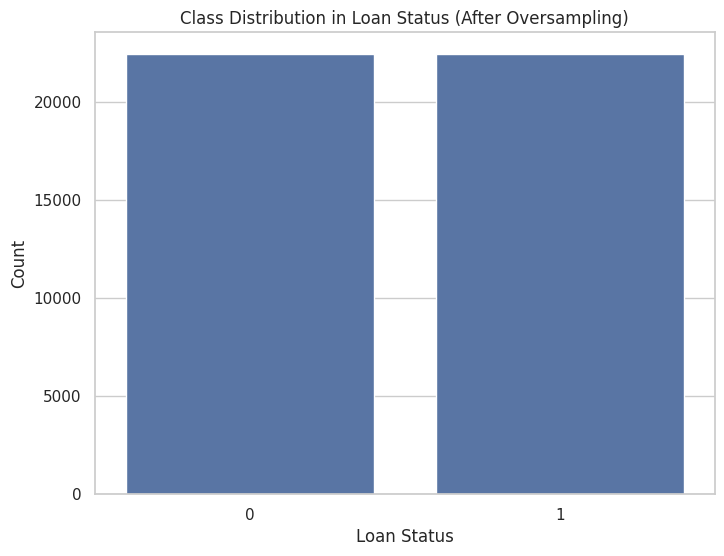

In [ ]:
# Apply SMOTE for oversampling
smote = SMOTE(sampling_strategy='auto', random_state=42)  # Initialize SMOTE
X_resampled, y_resampled = smote.fit_resample(X, target)  # Resample features and target

# Plot the class distribution after oversampling
plt.figure(figsize=(8, 6))
sns.countplot(x=y_resampled)  # Create a countplot of the resampled target
plt.title('Class Distribution in Loan Status (After Oversampling)')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.show()

In [ ]:
# Recombine the resampled features and target
X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
y_resampled_df = pd.DataFrame(y_resampled, columns=['loan_status'])
# Concatenate the resampled features and target into one DataFrame
ds = pd.concat([X_resampled_df, y_resampled_df], axis=1)

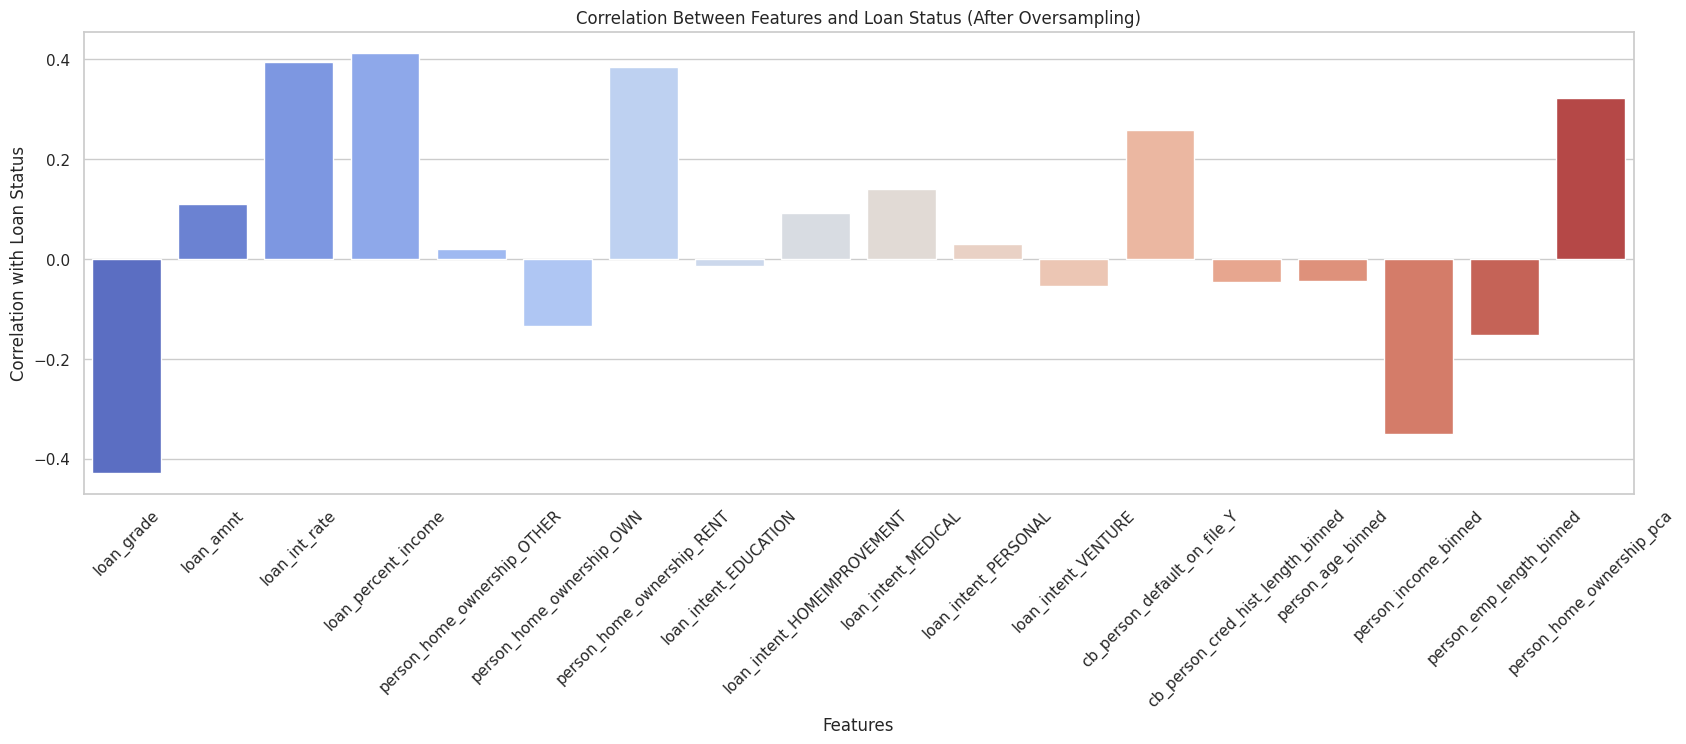

In [206]:
corr_matrix = ds.corr()['loan_status'].drop('loan_status')

plt.figure(figsize=(20, 6))
sns.barplot(x=corr_matrix.index, y=corr_matrix.values, hue=corr_matrix.index, palette="coolwarm", legend=False)
plt.title("Correlation Between Features and Loan Status (After Oversampling)")
plt.xlabel("Features")
plt.ylabel("Correlation with Loan Status")
plt.xticks(rotation=45)
plt.show()


# FEATURE SELECTION

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel


In [ ]:
# Define the target variable 'loan_status' and feature variables
X = ds.drop('loan_status', axis=1)
y = ds['loan_status']


In [ ]:
# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Initialize and train the Random Forest model
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=500, random_state=42)

In [ ]:
# Get the feature importances
feature_importances = pd.DataFrame(rf.feature_importances_, index=X.columns, columns=['importance'])
feature_importances = feature_importances.sort_values('importance', ascending=False)



print(feature_importances)

                                   importance
loan_percent_income                  0.190392
loan_grade                           0.132939
person_income_binned                 0.122965
loan_int_rate                        0.109626
person_emp_length_binned             0.087552
loan_amnt                            0.072734
person_home_ownership_RENT           0.071924
cb_person_cred_hist_length_binned    0.065865
person_age_binned                    0.061034
loan_intent_HOMEIMPROVEMENT          0.017929
loan_intent_MEDICAL                  0.015228
loan_intent_EDUCATION                0.011675
loan_intent_PERSONAL                 0.010737
person_home_ownership_OWN            0.010505
cb_person_default_on_file_Y          0.010218
loan_intent_VENTURE                  0.008112
person_home_ownership_OTHER          0.000563


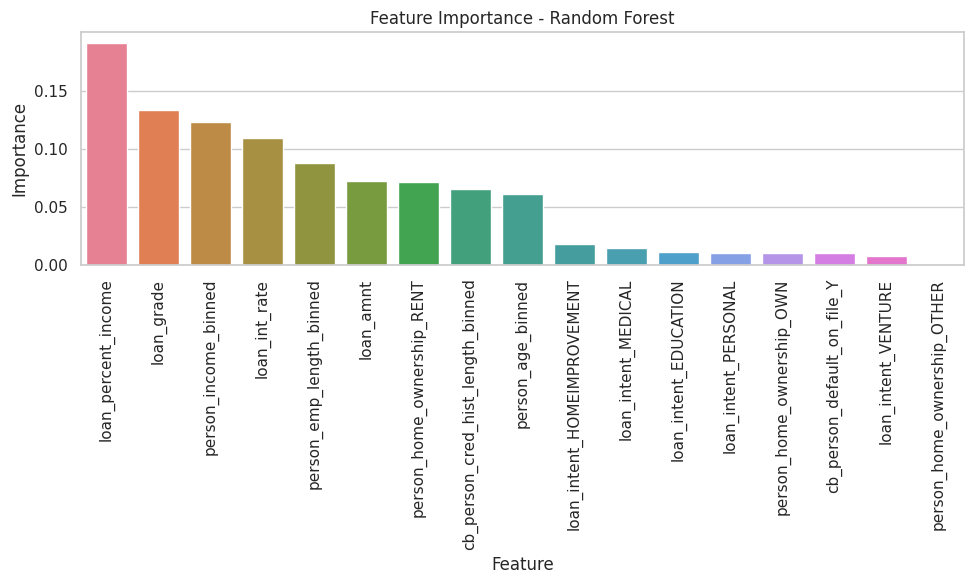

In [ ]:
# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.index,
            y=feature_importances['importance'],
            hue=feature_importances.index,
            legend=False
            )
plt.xticks(rotation=90)
plt.title('Feature Importance - Random Forest')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

In [ ]:
# Perform feature selection with SelectFromModel
sfm = SelectFromModel(rf, threshold=0.05, prefit=True)
X_selected = sfm.transform(X_train)

# Get the names of the selected features
selected_features = X.columns[sfm.get_support()]

# Print the selected features and their importance
for f in range(len(selected_features)):
    print(
        "%2d) %-*s %f"
        % (f + 1, 30, selected_features[f], feature_importances.loc[selected_features[f], "importance"])
    )

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


 1) loan_grade                     0.132939
 2) loan_amnt                      0.072734
 3) loan_int_rate                  0.109626
 4) loan_percent_income            0.190392
 5) person_home_ownership_RENT     0.071924
 6) cb_person_cred_hist_length_binned 0.065865
 7) person_age_binned              0.061034
 8) person_income_binned           0.122965
 9) person_emp_length_binned       0.087552


# XGboost_class

In [176]:
#!pip install optuna

import pandas as pd
import optuna
from xgboost import XGBClassifier, plot_tree, plot_importance
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# Define the features and target variable
selected_features = [
    'loan_grade', 'loan_amnt', 'loan_int_rate', 'loan_percent_income',
    'person_home_ownership_RENT', 'cb_person_cred_hist_length_binned',
    'person_age_binned', 'person_income_binned', 'person_emp_length_binned'
]

In [ ]:
# Add all features related to 'person_home_ownership'
home_ownership_columns = [col for col in ds.columns if 'person_home_ownership' in col]
selected_features.extend(home_ownership_columns)

# Drop duplicates
selected_features = list(set(selected_features))


In [ ]:
# Define X (features) and y (target variable)
X = ds[selected_features]
y = ds['loan_status']


In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert category columns to integer (or float) dtype
X_train = X_train.apply(lambda col: col.astype('category').cat.codes if col.dtype.name == 'category' else col)

# You may also want to do this for the validation or test set:
X_test = X_test.apply(lambda col: col.astype('category').cat.codes if col.dtype.name == 'category' else col)


In [ ]:
# Define the Optuna optimization function
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-5, 1e-1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        # 'scale_pos_weight': weight_pos_class
    }

    # Initialize the model with suggested hyperparameters
    model = XGBClassifier(**params, random_state=42)

    # Perform cross-validation to evaluate the model
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

    # Return the mean cross-validation score as the optimization objective (maximize accuracy)
    return cv_scores.mean()

# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Optimize the objective function
study.optimize(objective, n_trials=60)

[I 2024-12-07 10:00:04,415] A new study created in memory with name: no-name-ef727b1b-d914-4c87-8216-2a74f27fda04
[I 2024-12-07 10:01:07,575] Trial 0 finished with value: 0.9104461354580218 and parameters: {'n_estimators': 1800, 'learning_rate': 0.0016553624184166879, 'max_depth': 6, 'subsample': 0.8417260779262675, 'colsample_bytree': 0.865980966478344, 'gamma': 0.022400593201568803, 'min_child_weight': 9}. Best is trial 0 with value: 0.9104461354580218.
[I 2024-12-07 10:01:23,166] Trial 1 finished with value: 0.9117557079666854 and parameters: {'n_estimators': 1100, 'learning_rate': 0.004679708526824488, 'max_depth': 5, 'subsample': 0.6591448688075349, 'colsample_bytree': 0.6148443560279371, 'gamma': 0.007037159393443738, 'min_child_weight': 2}. Best is trial 1 with value: 0.9117557079666854.
[I 2024-12-07 10:01:33,264] Trial 2 finished with value: 0.8827776091802498 and parameters: {'n_estimators': 800, 'learning_rate': 0.0015094087933005765, 'max_depth': 3, 'subsample': 0.961017001

In [207]:
# Print the best trial found by Optuna
print("Best hyperparameters:", study.best_params)
print("Best cross-validation accuracy: {:.2f}".format(study.best_value))


Best hyperparameters: {'n_estimators': 1100, 'learning_rate': 0.07061268523788854, 'max_depth': 9, 'subsample': 0.8396953527145486, 'colsample_bytree': 0.8569068836672635, 'gamma': 0.00400814372532687, 'min_child_weight': 2}
Best cross-validation accuracy: 0.93


In [ ]:
# Use the best parameters to train the final model
best_params = study.best_params
xgb_best = XGBClassifier(**best_params, random_state=42)
xgb_best.fit(X_train, y_train)

# Predict and evaluate the model on the test dataset
y_pred = xgb_best.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the test dataset with optimized parameters: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy on the test dataset with optimized parameters: 0.93

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      4487
           1       0.95      0.91      0.93      4486

    accuracy                           0.93      8973
   macro avg       0.93      0.93      0.93      8973
weighted avg       0.93      0.93      0.93      8973



# PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
# Select columns related to 'person_home_ownership'
home_ownership_columns = [col for col in ds.columns if 'person_home_ownership' in col]

# Extract the data for PCA
home_ownership_data = ds[home_ownership_columns]

In [ ]:
# Standardize the data
scaler = StandardScaler()
home_ownership_scaled = scaler.fit_transform(home_ownership_data)

# Apply PCA to reduce to one component
pca = PCA(n_components=1)
home_ownership_pca = pca.fit_transform(home_ownership_scaled)

# Add the PCA component back to the dataset
ds['person_home_ownership_pca'] = home_ownership_pca

# Drop the original 'person_home_ownership' columns
# ds = ds.drop(columns=home_ownership_columns)

# Inspect the dataset with the new PCA feature
print(ds[['person_home_ownership_pca']].head(10))

   person_home_ownership_pca
0                   0.722853
1                  -3.713890
2                  -0.746886
3                   0.722853
4                   0.722853
5                  -3.713890
6                   0.722853
7                   0.722853
8                   0.722853
9                  -3.713890
